# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [7]:
from straeto import straeto
straeto.getBusPositionsFor(["55"])[0]

{'deviceNumber': 144,
 'gpsFix': 2,
 'gpsTime': '180503181935',
 'heading': 213.49,
 'lastStop': 20000131,
 'lat': 63.9719316666667,
 'lon': -22.5510666666667,
 'nextStop': 20000041,
 'pingCode': 6,
 'route': '55-B',
 'routeNumber': '55',
 'speed': 21.35}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

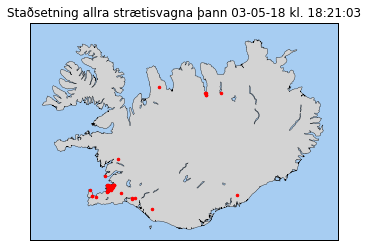

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings; warnings.filterwarnings('ignore')
from datetime import datetime

map = Basemap(projection='merc', resolution='h', urcrnrlat=66.8, urcrnrlon=-12.9, llcrnrlat=63.2, llcrnrlon=-25)
map.drawcoastlines(linewidth=0.35)
map.fillcontinents(color='lightgrey', lake_color='#a7cdf2')
map.drawmapboundary(fill_color='#a7cdf2')

for bus in straeto.getAllBusPositions():
    X, Y = map(bus['lon'], bus['lat'])
    map.plot(X, Y, 'ro', markersize=2.5)

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Einnig er liður að nafni 'speed'. Ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [67]:
import time
from geopy.distance import vincenty

p_buses = straeto.getAllBusPositions(); buses = p_buses
while buses == p_buses:
    buses = straeto.getAllBusPositions()
    time.sleep(1)
    
assert len(buses) == len(p_buses)
buses = sorted(buses, key=lambda bus: bus['deviceNumber']); p_buses = sorted(p_buses, key=lambda bus: bus['deviceNumber'])

Ks = []
for i in range(len(buses)):
    bus = buses[i]; p_bus = p_buses[i]
    if bus == p_bus:
        continue
    assert bus['deviceNumber'] == p_bus['deviceNumber']
    bus_coords = (bus['lat'], bus['lon']); p_bus_coords = (p_bus['lat'], p_bus['lon'])
    dist = vincenty(bus_coords, p_bus_coords).m
    bus_t = int(bus['gpsTime'][-2:]); p_bus_t = int(p_bus['gpsTime'][-2:])
    bus_t += 60 if bus_t < p_bus_t else False
    delta_t = bus_t - p_bus_t
    v_kmh = dist/delta_t
    if bus['speed']+p_bus['speed'] == 0:
        continue
    k = (2*v_kmh)/(bus['speed']+p_bus['speed'])
    Ks.append(k)
print("k = {}".format(sum(Ks)/len(Ks)))
print("1/k = {}".format(sum(Ks)/len(Ks)))
print(Ks)

ZeroDivisionError: float division by zero

## Undirbúningur gagna:

```
ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);
```
svo:
```
UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);
```

```
SELECT r.maxspeed FROM roads r, buses b WHERE ST_DWithin(b.geom, r.geom, 8) ORDER BY ST_Distance(r.geom, b.geom);
```

In [3]:
!ls

extract_roads  readme.md  straeto  straeto-notebook.ipynb
